# SVM Classifier with Polynomial Kernel and GridSearchCV for Hyperparameter Tuning

This notebook demonstrates the use of an SVM classifier with a polynomial kernel to classify website visitor data, with hyperparameter tuning using GridSearchCV. The goal is to predict whether a session resulted in a purchase or not based on various features.

## Step 1: Importing Necessary Libraries

In [14]:
#importing libraries

from datasets import load_dataset
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns   
import pandas as pd
import numpy as np


## Step 2: Loading and Splitting the Data

We will load the dataset and split it into training and test sets.

In [15]:
# Load dataset
ds = load_dataset("jlh/uci-shopper")
df = ds["train"].to_pandas()

# Separate features and target variable
X = df.drop(columns=["Revenue"])
y = df["Revenue"]

# Limit data for local testing
# X = X.sample(n=1000)
# y = y.loc[X.index]

# Train-test split (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 3: Preprocessing the Data

We need to preprocess both numerical and categorical features before passing them to the model. We'll use pipelines for this.


In [16]:
# Preprocess numerical features
numerical_features = X.select_dtypes(include=["float64", "int64"]).columns

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())      
])

# Preprocess categorical features
categorical_features = X.select_dtypes(include=["object", "bool"]).columns

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine numerical and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


## Step 4: Defining the Model and Hyperparameter Grid

We will now define the model (SVM classifier with a polynomial kernel) and the hyperparameter grid for tuning using GridSearchCV.

In [17]:
# Model construction
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(kernel="poly"))
])  

# Hyperparameter tuning
param_grid = {  
    "classifier__degree": [2, 3, 4, 7 ],
    "classifier__C": [0.1, 10, 100, 1000],
}


## Step 5: Model Training

Next, we'll use GridSearchCV to find the best hyperparameters for the model and to train the model. Then, we will evaluate the model's performance on the training set.

In [18]:
# Set up GridSearchCV with the pipeline, parameter grid, and cross-validation strategy
# n_jobs = -2 to use all available CPU cores except one
grid_search = GridSearchCV(model, param_grid, cv=5 , scoring='accuracy', n_jobs=-2)

# Fit the grid search to the data, which will automatically run cross-validation and select the best model
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best parameters: {best_params}')
print(f'Training Accuracy: {best_score:.4f}')


Best parameters: {'classifier__C': 100, 'classifier__degree': 2}
Training Accuracy: 0.8963


## Step 6: Evaluate Model on Test Set

We will now evaluate the model on the test set and print the accuracy.

In [19]:
# Evaluate the model on the test set
y_pred = grid_search.predict(X_test)
test_score = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_score:.4f}')


Test Accuracy: 0.8820


Now, randomly shuffling every feature and calculating how the accuracy of the model changes. This is called permutation importance and is used to see which features are the most impactful

In [29]:
from sklearn.inspection import permutation_importance
import pandas as pd

# Compute feature importance
result = permutation_importance(grid_search, X_test, y_test, scoring="accuracy", n_repeats=10, random_state=42)

# Sort and display the feature importance
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

print(feature_importance)

                    Feature  Importance
8                PageValues    0.095134
6               BounceRates    0.008232
7                 ExitRates    0.004461
4            ProductRelated    0.002839
9                SpecialDay    0.002433
0            Administrative    0.001541
10                    Month    0.001054
5   ProductRelated_Duration    0.000892
11         OperatingSystems    0.000365
15              VisitorType    0.000365
16                  Weekend    0.000243
3    Informational_Duration    0.000243
2             Informational   -0.000041
14              TrafficType   -0.000446
12                  Browser   -0.000608
13                   Region   -0.000730
1   Administrative_Duration   -0.000811


## Step 7: Visualizing the Data



### Numerical Features Distribution

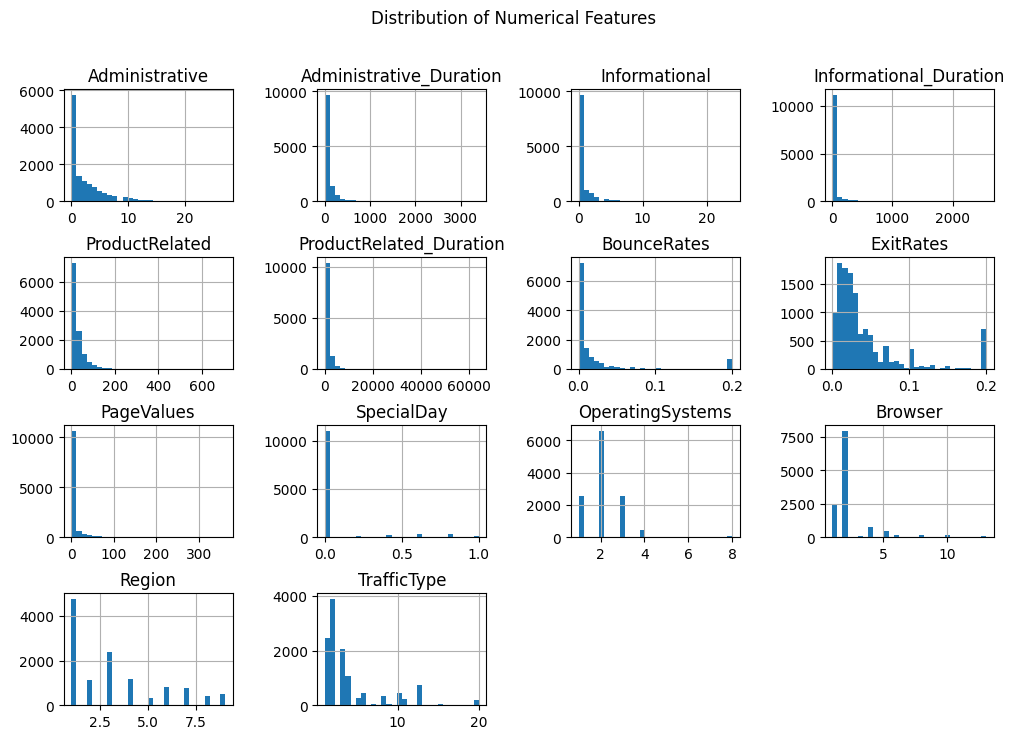

In [30]:
# Plot distribution for numerical features
numerical_features = X.select_dtypes(include=["float64", "int64"]).columns
X[numerical_features].hist(figsize=(12, 8), bins=30)
plt.suptitle('Distribution of Numerical Features')
plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust the space between plots
plt.show()


### Categorical Features Distribution

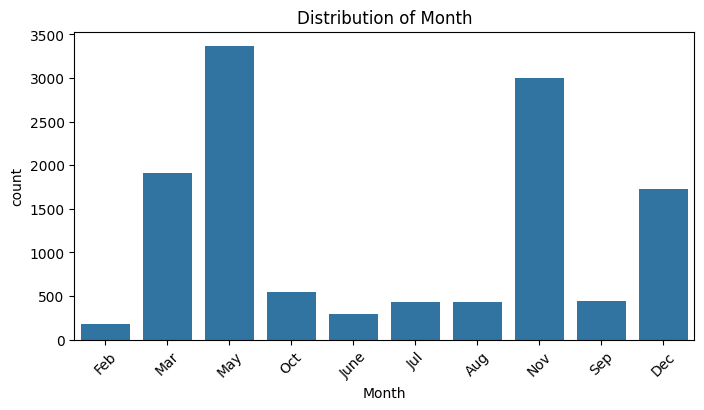

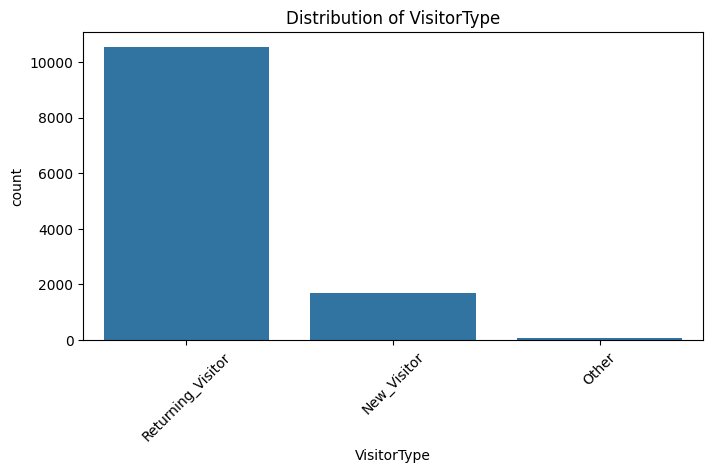

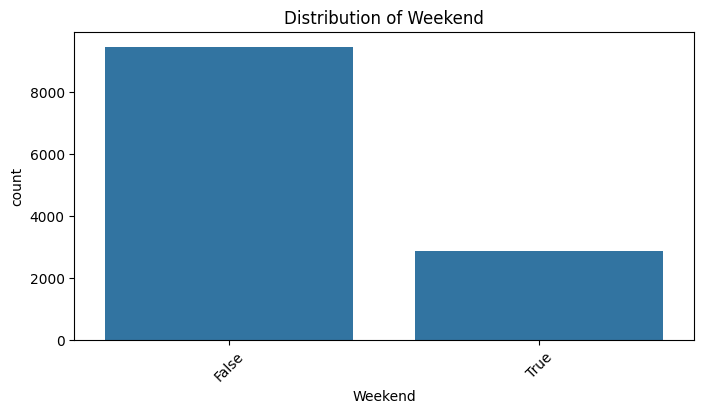

In [31]:
# Plot bar plot for categorical features
categorical_features = X.select_dtypes(include=["object", "bool"]).columns
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=feature, data=X)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.show()


### Correlation heatmap for numerical features

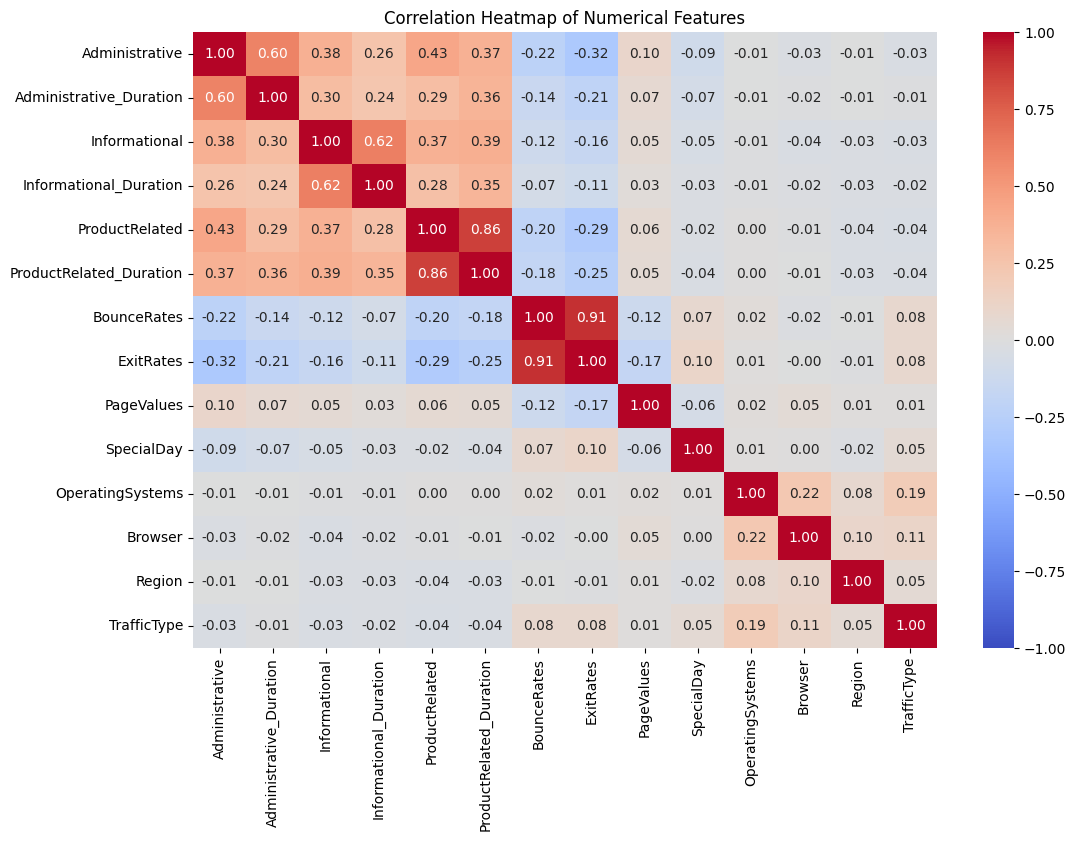

In [32]:
corr_matrix = X[numerical_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Visualize the distribution of the response variable

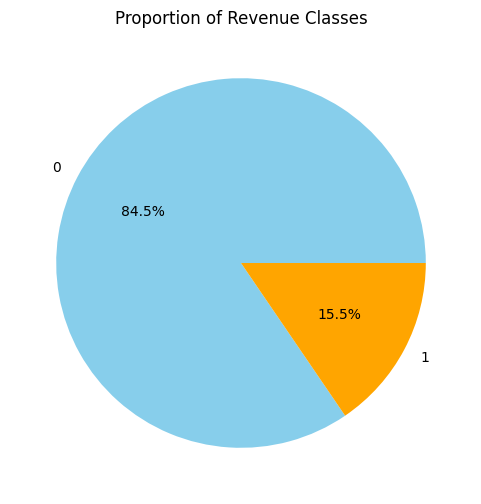

In [33]:
y.value_counts().plot(kind='pie', autopct='%1.1f%%', colors=["skyblue", "orange"], figsize=(6, 6))
plt.title("Proportion of Revenue Classes")
plt.ylabel("")  # Hide y-label
plt.show()

### Training and Test Accuracy

In [34]:
# Print the training and test accuracy

print(f'Training Accuracy: {best_score:.4f}')
print(f'Test Accuracy: {test_score:.4f}')


Training Accuracy: 0.8963
Test Accuracy: 0.8820


### Feature Importance

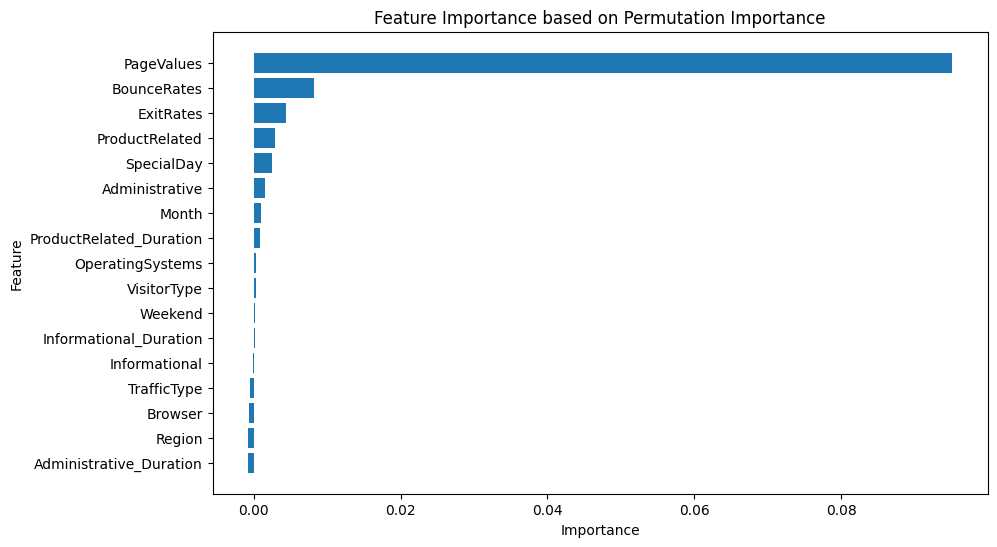

In [ ]:

import matplotlib.pyplot as plt

# Assuming `feature_importance` is already a DataFrame with 'Feature' and 'Importance' columns
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance based on Permutation Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

### Confusion Matrix

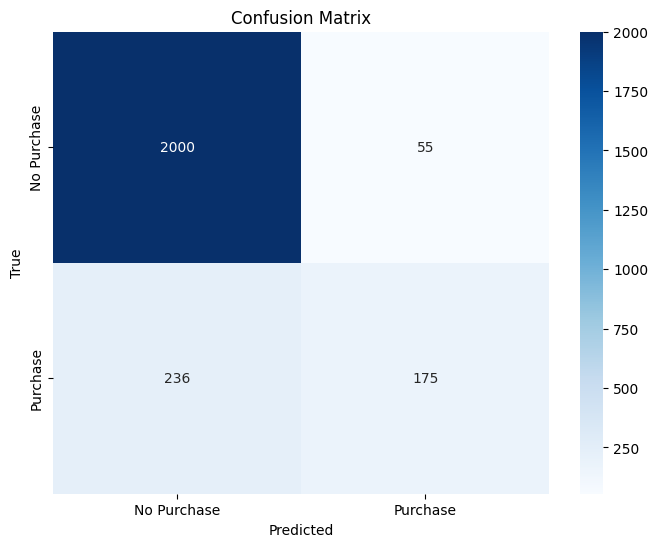

In [36]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Purchase', 'Purchase'], yticklabels=['No Purchase', 'Purchase'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Learning Curve for different sample sizes

The shaded area in the learning curve represents the standard deviation of accuracy scores across different cross-validation folds from the mean accuracy score

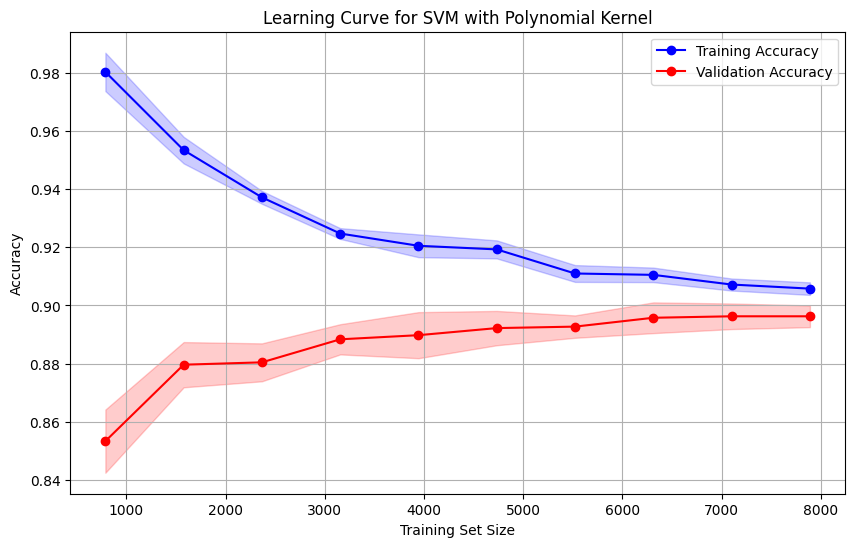

In [37]:
# Define range of training sizes to test
train_sizes = np.linspace(0.1, 1.0, 10)  # 10 different sizes from 10% to 100% of training data

# Compute learning curve
train_sizes_abs, train_scores, val_scores = learning_curve(
    grid_search.best_estimator_,  # Use the best model from GridSearchCV
    X_train, y_train,
    train_sizes=train_sizes,
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",
    n_jobs=-2  # Use all available CPU cores except one
)

# Compute mean and standard deviation for smooth curves
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_mean, "o-", color="blue", label="Training Accuracy")
plt.plot(train_sizes_abs, val_mean, "o-", color="red", label="Validation Accuracy")

# Add shaded area for standard deviation
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color="red")

# Labels and title
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for SVM with Polynomial Kernel")
plt.legend()
plt.grid()
plt.show()
